In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import cabi.etl.extract as extract
import cabi.cleaning as clean
import cabi.etl.transform as t

from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import create_engine

## This Notebook Will be for Cleaning/Transforming Data from Raw CSV files and Loading into a PostGIS database

In [2]:
# List of filenames
a, b, c = extract.build_paths(csv_url='csv')

csv_paths = extract.compile_paths(a,b,c)

raw_dfs = extract.import_csvs(csv_paths)



## The Columns Are Not All The Same

- Observe recent difference in col naming convention for the set

In [3]:
col_names = [df.columns for df in raw_dfs]
col_names

[Index(['Duration', 'Start date', 'End date', 'Start station number',
        'Start station', 'End station number', 'End station', 'Bike number',
        'Member type'],
       dtype='object'),
 Index(['Duration', 'Start date', 'End date', 'Start station number',
        'Start station', 'End station number', 'End station', 'Bike number',
        'Member type'],
       dtype='object'),
 Index(['Duration', 'Start date', 'End date', 'Start station number',
        'Start station', 'End station number', 'End station', 'Bike number',
        'Member type'],
       dtype='object'),
 Index(['Duration', 'Start date', 'End date', 'Start station number',
        'Start station', 'End station number', 'End station', 'Bike number',
        'Member type'],
       dtype='object'),
 Index(['Duration', 'Start date', 'End date', 'Start station number',
        'Start station', 'End station number', 'End station', 'Bike number',
        'Member type'],
       dtype='object'),
 Index(['Duration', 'Star

## But the Information Is Roughly The Same
- Notably different items are:
    - Rideable Type (All of the old sets are presumed to be Docked Bikes)
    - Missing Lat/Lng (need an imputation strategy)
    - Different Station ID/Numbering Convention (not a huge deal)
    - No Unique Ride ID (we'll want to add this if using this Data)

In [4]:
legacy_list = raw_dfs[:-4]
legacy_list[-1].head()

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,1596,2020-03-01 00:01:16,2020-03-01 00:27:52,31646,Maine Ave & 9th St SW,31509,New Jersey Ave & R St NW,W24217,Member
1,448,2020-03-01 00:02:04,2020-03-01 00:09:32,31646,Maine Ave & 9th St SW,31272,Washington & Independence Ave SW/HHS,W21897,Member
2,283,2020-03-01 00:03:45,2020-03-01 00:08:28,31224,18th & L St NW,31200,Massachusetts Ave & Dupont Circle NW,W21703,Member
3,642,2020-03-01 00:05:49,2020-03-01 00:16:31,31603,1st & M St NE,31611,13th & H St NE,78571,Member
4,347,2020-03-01 00:06:53,2020-03-01 00:12:40,31101,14th & V St NW,31114,18th St & Wyoming Ave NW,W23425,Member


### Quick check to make sure column names are consistent

In [7]:
def check_col_names(df1, df2, cols_only=True):
    """Return True or False indicating whether or not the column names are the same between two dataframes"""
    # Default is that columns are passed, for ease of use
    # with check_col_list below
    # will return truth value for each column pair, so we achieve
    # one truth value for the whole array/list by calling all
    if cols_only:
        result = all(df1 == df2)
    # Also possible to pass two dataframes directly by specifying
    # cols_only=False
    else:
        result = all(df1.columns == df2.columns)
    # Return True/False result
    return result

def check_col_list(df_list):
    """Accepts list of dataframes, calls check_col_names on the df columns
    returns False if any False values, true otherwise"""
    
    # Build dict of df columns keyed by position in list
    # Only pull the columns to save some space
    # Save as dict to make returning the mismatches easier on
    # later edit
    col_dict = {i: df.columns for i, df in enumerate(df_list)}
    
    # build list of keys for cleaner reading below
    keys = list(col_dict.keys())
    
    
    # Because we are only interested in if there are any False values
    # we can compare one df to all others by the logic that if a==b,
    # a==c, a==d, etc. then a==b==c==d and so on
#     results = [check_col_names(col_dict[0], col_dict[key]) for key in keys]
    
#     # return True only if all are true
    
#     return all(results)
    return col_dict[0]
    
    
# print(check_col_names(historical_list[0], historical_list[-1], cols_only=False))
# print(check_col_names(historical_list[0].columns, historical_list[-1].columns))

check_col_list(raw_dfs[:-4])
      

Index(['Duration', 'Start date', 'End date', 'Start station number',
       'Start station', 'End station number', 'End station', 'Bike number',
       'Member type'],
      dtype='object')

In [7]:
historical_list[0].columns == historical_list[-1].columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

In [5]:
def drop_legacy_cols(df):
    """Accepts df in raw format from prior to April of 2020
    Returns same df without the columns ['Duration', 'Start station number', 
    'End station number', 'Bike number'] Duration is created later in
    cleaning process to ensure consistent results Station Number cols
    duplicate information in station name cols and are of different 
    format to current numbering scheme, bike number is unavailable in
    current datasets"""
    return df.drop(['Duration', 'Start station number', 'End station number', 'Bike number'], axis=1)



In [9]:
drop_legacy_cols(legacy_list[0])

,Start date,End date,Start station,End station,Member type
0,2018-01-01 00:05:06,2018-01-01 00:14:18,Adams Mill & Columbia Rd NW,Georgia & New Hampshire Ave NW,Member
1,2018-01-01 00:14:30,2018-01-01 00:35:53,15th St & Constitution Ave NW,15th St & Constitution Ave NW,Casual
2,2018-01-01 00:14:53,2018-01-01 00:35:58,15th St & Constitution Ave NW,15th St & Constitution Ave NW,Casual
3,2018-01-01 00:15:31,2018-01-01 00:25:09,14th & Upshur St NW,16th & Harvard St NW,Casual
4,2018-01-01 00:18:02,2018-01-01 00:24:15,4th & East Capitol St NE,Lincoln Park / 13th & East Capitol St NE,Member
...,...,...,...,...,...
168585,2018-01-31 23:50:17,2018-02-01 00:13:14,Massachusetts Ave & Dupont Circle NW,5th St & Massachusetts Ave NW,Casual
168586,2018-01-31 23:52:43,2018-02-01 00:05:24,1st & M St NE,1st & K St SE,Member
168587,2018-01-31 23:54:27,2018-02-01 00:06:45,Lamont & Mt Pleasant NW,18th St & Wyoming Ave NW,Member
168588,2018-01-31 23:56:31,2018-02-01 00:00:38,Columbus Circle / Union Station,D St & Maryland Ave NE,Member


In [5]:
def rename_legacy_cols(df):
    """Renames columns of dataframe in format consistent with the current naming scheme"""
    return df.rename(
        columns={'Start date':'started_at',
                 'End date': 'ended_at',
                 'Start station':'start_station_name',
                 'End station': 'end_station_name',
                 'Member type': 'member_casual'}
    )

# rename_legacy_cols(historical_list[0])

In [12]:
# Drop incompatible columns
legacy_list = [df.drop(['Duration', 'Start station number', 'End station number', 'Bike number'], axis=1) for df in legacy_list]

In [17]:
legacy_list[0].head()

,Start date,End date,Start station,End station,Member type
0,2018-01-01 00:05:06,2018-01-01 00:14:18,Adams Mill & Columbia Rd NW,Georgia & New Hampshire Ave NW,Member
1,2018-01-01 00:14:30,2018-01-01 00:35:53,15th St & Constitution Ave NW,15th St & Constitution Ave NW,Casual
2,2018-01-01 00:14:53,2018-01-01 00:35:58,15th St & Constitution Ave NW,15th St & Constitution Ave NW,Casual
3,2018-01-01 00:15:31,2018-01-01 00:25:09,14th & Upshur St NW,16th & Harvard St NW,Casual
4,2018-01-01 00:18:02,2018-01-01 00:24:15,4th & East Capitol St NE,Lincoln Park / 13th & East Capitol St NE,Member


In [19]:
historical_list = [df.rename(columns={'Start date':'started_at',
                                     'End date': 'ended_at',
                                     'Start station':'start_station_name',
                                     'End station': 'end_station_name',
                                     'Member type': 'member_casual'}) for df in historical_list]
historical_df = pd.concat(historical_list)
historical_df

,started_at,ended_at,start_station_name,end_station_name,member_casual
0,2018-01-01 00:05:06,2018-01-01 00:14:18,Adams Mill & Columbia Rd NW,Georgia & New Hampshire Ave NW,Member
1,2018-01-01 00:14:30,2018-01-01 00:35:53,15th St & Constitution Ave NW,15th St & Constitution Ave NW,Casual
2,2018-01-01 00:14:53,2018-01-01 00:35:58,15th St & Constitution Ave NW,15th St & Constitution Ave NW,Casual
3,2018-01-01 00:15:31,2018-01-01 00:25:09,14th & Upshur St NW,16th & Harvard St NW,Casual
4,2018-01-01 00:18:02,2018-01-01 00:24:15,4th & East Capitol St NE,Lincoln Park / 13th & East Capitol St NE,Member
...,...,...,...,...,...
162525,2020-03-31 23:17:58,2020-03-31 23:29:12,19th St & Constitution Ave NW,5th St & Massachusetts Ave NW,Member
162526,2020-03-31 23:18:13,2020-03-31 23:26:47,14th & Rhode Island Ave NW,18th & New Hampshire Ave NW,Member
162527,2020-03-31 23:29:00,2020-03-31 23:54:25,20th St & Florida Ave NW,5th & Kennedy St NW,Member
162528,2020-03-31 23:41:17,2020-03-31 23:50:43,1st & M St NE,10th & E St NW,Member


In [6]:


def legacy_to_recent(df):
    """Returns df formatted in the same style as employed from April of 2020
    by calling drop/rename legacy cols funcs in succession, adding a rideable_type
    and correcting type-case of the member_casual column 
    """
    new_df = drop_legacy_cols(df)
    new_df = rename_legacy_cols(new_df)
    # impute rideable type since ebikes were not rolled out until after
    # any of these data sets were released
    new_df['rideable_type'] = 'docked_bike'
    # convert values to lower case
    new_df['member_casual'] = new_df.member_casual.str.lower()
    
    return new_df

# legacy_to_recent(historical_list[-1])
    

In [12]:
historical_list = [legacy_to_recent(df) for df in historical_list]
historical_list

[                 started_at             ended_at  \
 0       2018-01-01 00:05:06  2018-01-01 00:14:18   
 1       2018-01-01 00:14:30  2018-01-01 00:35:53   
 2       2018-01-01 00:14:53  2018-01-01 00:35:58   
 3       2018-01-01 00:15:31  2018-01-01 00:25:09   
 4       2018-01-01 00:18:02  2018-01-01 00:24:15   
 ...                     ...                  ...   
 168585  2018-01-31 23:50:17  2018-02-01 00:13:14   
 168586  2018-01-31 23:52:43  2018-02-01 00:05:24   
 168587  2018-01-31 23:54:27  2018-02-01 00:06:45   
 168588  2018-01-31 23:56:31  2018-02-01 00:00:38   
 168589  2018-01-31 23:58:28  2018-02-01 00:14:22   
 
                           start_station_name  \
 0                Adams Mill & Columbia Rd NW   
 1              15th St & Constitution Ave NW   
 2              15th St & Constitution Ave NW   
 3                        14th & Upshur St NW   
 4                   4th & East Capitol St NE   
 ...                                      ...   
 168585  Massachuse

In [23]:
historical_df['rideable_type'] = 'docked_bike'
historical_df['member_casual'] = historical_df.member_casual.str.lower()
cols = [col for col in historical_df.columns]
cols

['started_at',
 'ended_at',
 'start_station_name',
 'end_station_name',
 'member_casual',
 'rideable_type']

In [25]:
cols = [cols[-1]] + cols[:-1]
cols

['rideable_type',
 'started_at',
 'ended_at',
 'start_station_name',
 'end_station_name',
 'member_casual']

In [7]:
def join_legacy(df_list):
    """Returns one DataFrame in current format from list of legacy
    formatted dataframes"""
    # format each dataframe in the list, combine them into one new dataframe with a new index
    full = pd.concat([legacy_to_recent(df) for df in df_list], ignore_index=True)
    # Allowing us to keep the ride_id column for the newer dataframes since none of the existing
    # ride ids are integers
    full['ride_id'] = pd.Series(range(len(full)))
    # The columns are slightly out of order, since we defined a new column 'rideable_type'
    # with our legacy_to_recent function which is the second column in the new format.
    # and then defined a ride_id which is the first. We first reorder the columns:
    cols = [col for col in full.columns]
    cols = [cols[-1], cols[-2]] + cols[:-2]
    # And then reindex the new dataframe
    full = full[cols]
    
    return full
    

In [9]:
join_legacy(raw_dfs[:-4])

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual
0,0,docked_bike,2018-01-01 00:05:06,2018-01-01 00:14:18,Adams Mill & Columbia Rd NW,Georgia & New Hampshire Ave NW,member
1,1,docked_bike,2018-01-01 00:14:30,2018-01-01 00:35:53,15th St & Constitution Ave NW,15th St & Constitution Ave NW,casual
2,2,docked_bike,2018-01-01 00:14:53,2018-01-01 00:35:58,15th St & Constitution Ave NW,15th St & Constitution Ave NW,casual
3,3,docked_bike,2018-01-01 00:15:31,2018-01-01 00:25:09,14th & Upshur St NW,16th & Harvard St NW,casual
4,4,docked_bike,2018-01-01 00:18:02,2018-01-01 00:24:15,4th & East Capitol St NE,Lincoln Park / 13th & East Capitol St NE,member
...,...,...,...,...,...,...,...
7478496,7478496,docked_bike,2020-03-31 23:17:58,2020-03-31 23:29:12,19th St & Constitution Ave NW,5th St & Massachusetts Ave NW,member
7478497,7478497,docked_bike,2020-03-31 23:18:13,2020-03-31 23:26:47,14th & Rhode Island Ave NW,18th & New Hampshire Ave NW,member
7478498,7478498,docked_bike,2020-03-31 23:29:00,2020-03-31 23:54:25,20th St & Florida Ave NW,5th & Kennedy St NW,member
7478499,7478499,docked_bike,2020-03-31 23:41:17,2020-03-31 23:50:43,1st & M St NE,10th & E St NW,member


In [27]:
historical_df = historical_df[cols]

In [15]:
def drop_recent_cols(df):
    """Accepts a dataframe from April of 2020 or later
    Returns dataframe suitable for a temporary join with historical data
    to demonstrate decisions made in EDA process as discussed in Technical
    Notebook"""
    return df.drop(['start_station_id', 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng'], axis=1)

def drop_equity(df):
    """This column appears in only one dataframe and is no longer reported"""
    if 'is_equity' in df.columns:
        result = df.drop('is_equity', axis=1)
    else:
        result = df
    
    return result
    


In [16]:
print(raw_dfs[-3].columns)
drop_equity(raw_dfs[-3])

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'is_equity'],
      dtype='object')


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,194551D7D0408225,docked_bike,2020-05-31 16:01:38,2020-05-31 16:23:05,Maine Ave & 7th St SW,95,1st & M St NE,65.0,38.8787,-77.0231,38.9057,-77.0056,casual
1,8AE9CED0F5BF8C69,docked_bike,2020-05-15 20:27:22,2020-05-15 20:43:39,17th St & Independence Ave SW,453,18th St & Wyoming Ave NW,76.0,38.8881,-77.0383,38.9188,-77.0416,member
2,DA316A2F8B6F1379,docked_bike,2020-05-27 09:30:37,2020-05-27 09:44:41,1st & Rhode Island Ave NW,60,18th St & Pennsylvania Ave NW,180.0,38.9154,-77.0123,38.8997,-77.0415,member
3,8E124F29987F9622,docked_bike,2020-05-16 13:06:23,2020-05-16 13:24:33,Constitution Ave & 2nd St NW/DOL,305,USDA / 12th & C St SW,117.0,38.8923,-77.0139,38.8863,-77.0282,member
4,1F3FE727B1983E23,docked_bike,2020-05-07 13:57:18,2020-05-07 14:20:49,Kingman Island/The Fields at RFK,645,Anacostia Park,553.0,38.8960,-76.9678,38.8734,-76.9834,casual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148981,79A715B12B9504FA,docked_bike,2020-05-25 12:18:51,2020-05-25 12:41:02,4th St & K St NW,456,1st & M St SE,578.0,38.9024,-77.0160,38.8769,-77.0061,casual
148982,E9CAA2C988D2E978,docked_bike,2020-05-29 17:23:20,2020-05-29 18:31:42,3rd & H St NE,137,15th St & Constitution Ave NW,531.0,38.9004,-77.0019,38.8922,-77.0332,casual
148983,F535B056898AC0F4,docked_bike,2020-05-31 15:34:21,2020-05-31 15:58:12,Eastern Market Metro / Pennsylvania Ave & 7th ...,120,17th & G St NW,395.0,38.8840,-76.9954,38.8983,-77.0397,casual
148984,AB954A5912CC58FD,docked_bike,2020-05-31 01:38:40,2020-05-31 01:38:27,12th & U St NW,299,37th & O St NW / Georgetown University,152.0,38.9168,-77.0281,38.9077,-77.0717,casual


In [20]:
recent_list = raw_dfs[-4:]
recent_list[1] = recent_list[1].drop('is_equity', axis=1)

# Drop incompatible columns
recent_list = [df.drop(['ride_id', 'start_station_id', 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng'], axis=1) for df in recent_list]
recent_list[0]
recent_df = pd.concat(recent_list)
recent_df

,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual
0,docked_bike,2020-04-27 10:33:08,2020-04-27 10:53:26,4th & M St SW,New York Ave & 15th St NW,member
1,docked_bike,2020-04-27 11:20:07,2020-04-27 11:42:55,17th & K St NW,4th & M St SW,member
2,docked_bike,2020-04-27 09:45:45,2020-04-27 09:54:32,1st & M St SE,4th & M St SW,member
3,docked_bike,2020-04-14 13:16:54,2020-04-14 13:28:59,11th & Kenyon St NW,Thomas Circle,casual
4,docked_bike,2020-04-19 20:42:25,2020-04-19 20:51:12,13th & H St NE,Eastern Market / 7th & North Carolina Ave SE,member
...,...,...,...,...,...,...
228297,docked_bike,2020-07-31 15:15:45,2020-07-31 16:25:22,5th & Kennedy St NW,Mount Vernon Ave & Four Mile Run Park,member
228298,docked_bike,2020-07-20 19:35:00,2020-07-20 19:56:18,TJ Cmty Ctr / 2nd St & S Old Glebe Rd,N Lynn St & Fairfax Dr,casual
228299,docked_bike,2020-07-01 16:56:24,2020-07-01 19:44:04,22nd & P ST NW,Adams Mill & Columbia Rd NW,casual
228300,docked_bike,2020-07-29 21:00:38,2020-07-29 21:35:10,Maine Ave & 7th St SW,Maine Ave & 7th St SW,casual


In [6]:
merged = clean.merge_all(raw_dfs[:-4], raw_dfs[-4:])
merged

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual
0,0,docked_bike,2018-01-01 00:05:06,2018-01-01 00:14:18,Adams Mill & Columbia Rd NW,Georgia & New Hampshire Ave NW,member
1,1,docked_bike,2018-01-01 00:14:30,2018-01-01 00:35:53,15th St & Constitution Ave NW,15th St & Constitution Ave NW,casual
2,2,docked_bike,2018-01-01 00:14:53,2018-01-01 00:35:58,15th St & Constitution Ave NW,15th St & Constitution Ave NW,casual
3,3,docked_bike,2018-01-01 00:15:31,2018-01-01 00:25:09,14th & Upshur St NW,16th & Harvard St NW,casual
4,4,docked_bike,2018-01-01 00:18:02,2018-01-01 00:24:15,4th & East Capitol St NE,Lincoln Park / 13th & East Capitol St NE,member
...,...,...,...,...,...,...,...
8145028,CD03F80ACB9AF2F4,docked_bike,2020-07-31 15:15:45,2020-07-31 16:25:22,5th & Kennedy St NW,Mount Vernon Ave & Four Mile Run Park,member
8145029,A0060CB4B9B17F32,docked_bike,2020-07-20 19:35:00,2020-07-20 19:56:18,TJ Cmty Ctr / 2nd St & S Old Glebe Rd,N Lynn St & Fairfax Dr,casual
8145030,E7BC1FE6BF9571F4,docked_bike,2020-07-01 16:56:24,2020-07-01 19:44:04,22nd & P ST NW,Adams Mill & Columbia Rd NW,casual
8145031,B73B5EB431B2BA1E,docked_bike,2020-07-29 21:00:38,2020-07-29 21:35:10,Maine Ave & 7th St SW,Maine Ave & 7th St SW,casual


In [9]:
def clean_merged(df):
    """Quick wrapper to allow datetime operations during EDA"""
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    merged_df = df.set_index('started_at')
    merged_df = merged_df.sort_index()
    return merged_df

In [11]:
merged = clean_merged(merged)

In [14]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8145033 entries, 2018-01-01 00:05:06 to 2020-07-31 23:59:46
Data columns (total 6 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   ended_at            datetime64[ns]
 3   start_station_name  object        
 4   end_station_name    object        
 5   member_casual       object        
dtypes: datetime64[ns](1), object(5)
memory usage: 435.0+ MB


In [19]:
merged.describe(datetime_is_numeric=False)

<ipython-input-19-aadfba44f64e>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  merged.describe(datetime_is_numeric=False)


,ride_id,rideable_type,ended_at,start_station_name,end_station_name,member_casual
count,8145033,8145033,8145033,8141061,8137542,8145033
unique,8145033,2,7335248,695,695,2
top,27CF1F86404F3020,docked_bike,2020-07-23 11:24:51,Columbus Circle / Union Station,Columbus Circle / Union Station,member
freq,1,8129184,16,134536,144759,6579624
first,NaN,NaN,2018-01-01 00:14:18,NaN,NaN,NaN
last,NaN,NaN,2020-08-10 20:25:12,NaN,NaN,NaN


In [18]:
merged[merged.ended_at == merged.ended_at.max()]

,ride_id,rideable_type,ended_at,start_station_name,end_station_name,member_casual
started_at,,,,,,
2020-07-26 19:52:45,90DC38C0401BC132,docked_bike,2020-08-10 20:25:12,Falls Church City Hall / Park Ave & Little Fal...,Falls Church City Hall / Park Ave & Little Fal...,casual


In [138]:
merged

,rideable_type,ended_at,start_station_name,end_station_name,member_casual
started_at,,,,,
2018-01-01 00:05:06,docked_bike,2018-01-01 00:14:18,Adams Mill & Columbia Rd NW,Georgia & New Hampshire Ave NW,member
2018-01-01 00:14:30,docked_bike,2018-01-01 00:35:53,15th St & Constitution Ave NW,15th St & Constitution Ave NW,casual
2018-01-01 00:14:53,docked_bike,2018-01-01 00:35:58,15th St & Constitution Ave NW,15th St & Constitution Ave NW,casual
2018-01-01 00:15:31,docked_bike,2018-01-01 00:25:09,14th & Upshur St NW,16th & Harvard St NW,casual
2018-01-01 00:18:02,docked_bike,2018-01-01 00:24:15,4th & East Capitol St NE,Lincoln Park / 13th & East Capitol St NE,member
...,...,...,...,...,...
2020-07-31 23:59:19,docked_bike,2020-08-01 00:10:33,Columbia Rd & Georgia Ave NW,Edgewood Rec Center,casual
2020-07-31 23:59:31,docked_bike,2020-08-01 00:08:07,Eastern Market Metro / Pennsylvania Ave & 7th ...,Massachusetts Ave & 6th St NE,member
2020-07-31 23:59:39,docked_bike,2020-08-01 00:18:36,Henry Bacon Dr & Lincoln Memorial Circle NW,New Hampshire Ave & Ward Pl NW,casual


In [137]:
merged.to_pickle('../data/wip/merged.pkl')

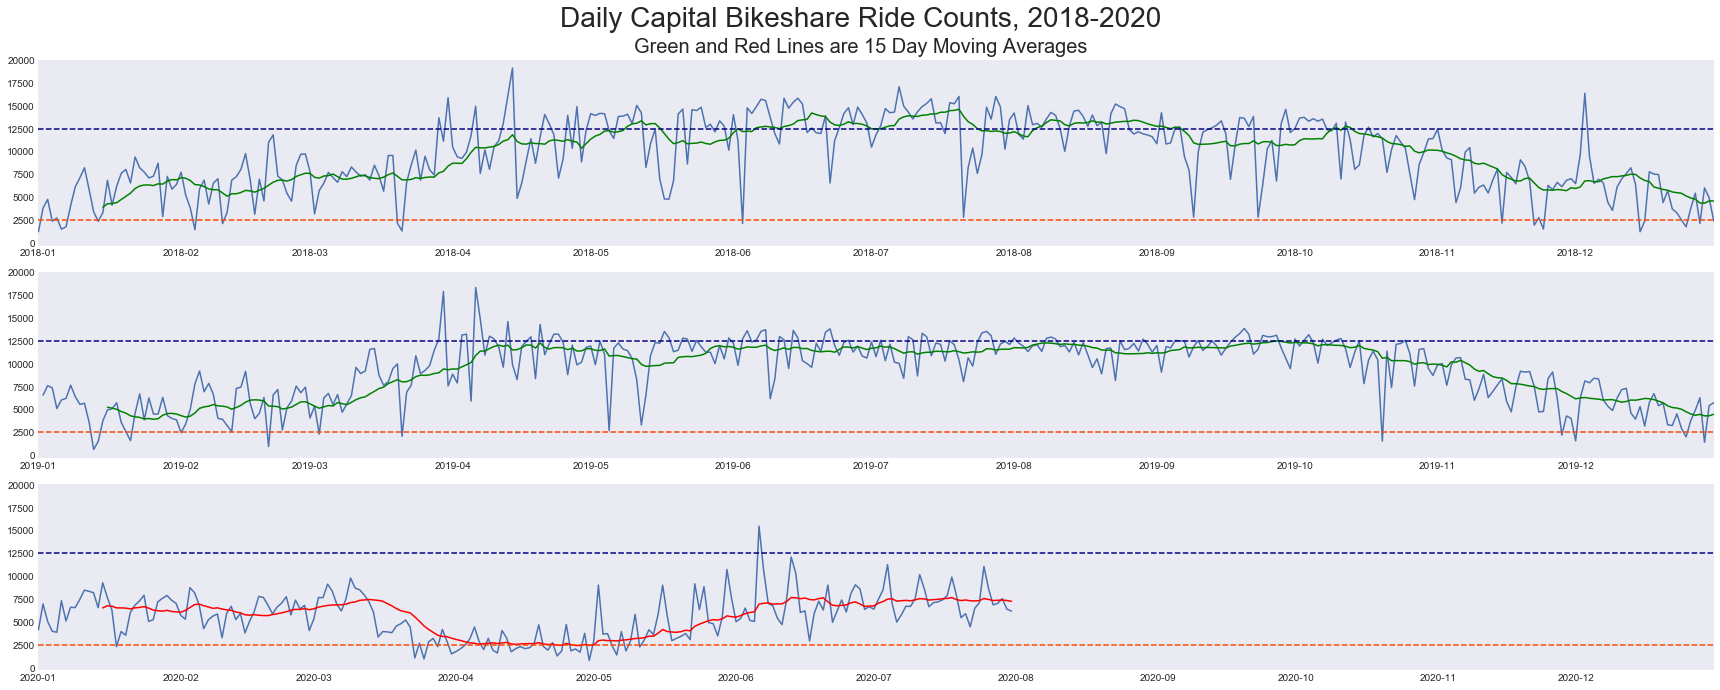

In [136]:
import matplotlib.pyplot as plt
import datetime as dt

daily_counts = merged.resample('D').count()

def plot_daily_counts(daily_counts):
    """Helper function for streamlining technical notebook"""
    fig, (axe, axe1, axe2) = plt.subplots(3, 1, sharey=True, figsize=(24, 9))

    plt.style.use('seaborn-deep')


    daily_counts = daily_counts.rideable_type

    nineteen = daily_counts[(daily_counts.index < '2020-01-01') & (daily_counts.index > '2019-01-01')]
    eighteen = daily_counts[daily_counts.index < '2019-01-01']
    twenty = daily_counts[daily_counts.index >= '2020-01-01']

    # Moving averages
    rolling_eighteen = eighteen.rolling(window=15).mean()
    rolling_nineteen = nineteen.rolling(window=15).mean()
    rolling_twenty = twenty.rolling(window=15).mean()


    axe.plot(eighteen)
    axe.plot(rolling_eighteen, color = 'green')
    axe.axhline(y=12500, ls = '--', color='navy')
    axe.axhline(y=2500, ls = '--', color='orangered')
    axe.set_xlim([dt.date(2018, 1, 1), dt.date(2018, 12, 31)])

    axe1.plot(nineteen)
    axe1.plot(rolling_nineteen, color = 'green')
    axe1.axhline(y=12500, ls = '--', color='navy')
    axe1.axhline(y=2500, ls = '--', color='orangered')
    axe1.set_xlim([dt.date(2019, 1, 1), dt.date(2019, 12, 31)])


    axe2.plot(twenty)
    axe2.plot(rolling_twenty, color = 'red')
    axe2.axhline(y=12500, ls = '--', color='navy')
    axe2.axhline(y=2500, ls = '--', color='orangered')
    axe2.set_xlim([dt.date(2020, 1, 1), dt.date(2020, 12, 31)])





    fig.suptitle('Daily Capital Bikeshare Ride Counts, 2018-2020', y=1.06, fontsize=28)
    fig.text(s='Green and Red Lines are 15 Day Moving Averages', x=0.5, horizontalalignment='center', y=.99, fontsize=20)
    fig.tight_layout()
    # fig.savefig('../figures/dailyridecounts.png', bbox_inches='tight')

    return fig, (axe, axe1, axe2)


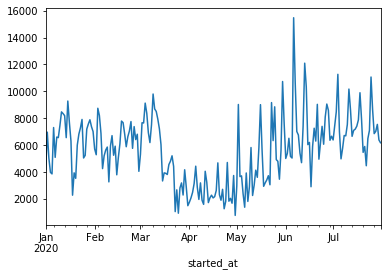

In [74]:
fig, ax = plt.subplots(figsize=(10,10))
twenty.plot()
ax.set_xlim(dt.date)

## For Now, Let's Just Use the Recent Data

In [14]:
april_to_july_list = raw_dfs[-4:]
april_to_july_list[1] = april_to_july_list[1].drop('is_equity', axis=1)

raw_apr_to_jul_df = pd.concat(april_to_july_list)
raw_apr_to_jul_df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,495C10604A58ACA9,docked_bike,2020-04-27 10:33:08,2020-04-27 10:53:26,4th & M St SW,21.0,New York Ave & 15th St NW,124.0,38.876700,-77.017800,38.899000,-77.033400,member
1,08A5138C88D182A5,docked_bike,2020-04-27 11:20:07,2020-04-27 11:42:55,17th & K St NW,100.0,4th & M St SW,21.0,38.902800,-77.038600,38.876700,-77.017800,member
2,505E308BDCA9C792,docked_bike,2020-04-27 09:45:45,2020-04-27 09:54:32,1st & M St SE,578.0,4th & M St SW,21.0,38.876900,-77.006100,38.876700,-77.017800,member
3,D3436FC6CCF04110,docked_bike,2020-04-14 13:16:54,2020-04-14 13:28:59,11th & Kenyon St NW,15.0,Thomas Circle,178.0,38.929500,-77.027800,38.905900,-77.032500,casual
4,37B8457C89257BD5,docked_bike,2020-04-19 20:42:25,2020-04-19 20:51:12,13th & H St NE,97.0,Eastern Market / 7th & North Carolina Ave SE,96.0,38.900400,-76.988300,38.887000,-76.996800,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
228297,CD03F80ACB9AF2F4,docked_bike,2020-07-31 15:15:45,2020-07-31 16:25:22,5th & Kennedy St NW,86.0,Mount Vernon Ave & Four Mile Run Park,455.0,38.956555,-77.019814,38.843422,-77.064016,member
228298,A0060CB4B9B17F32,docked_bike,2020-07-20 19:35:00,2020-07-20 19:56:18,TJ Cmty Ctr / 2nd St & S Old Glebe Rd,361.0,N Lynn St & Fairfax Dr,491.0,38.869418,-77.095596,38.893860,-77.070862,casual
228299,E7BC1FE6BF9571F4,docked_bike,2020-07-01 16:56:24,2020-07-01 19:44:04,22nd & P ST NW,437.0,Adams Mill & Columbia Rd NW,17.0,38.909394,-77.048728,38.922925,-77.042581,casual
228300,B73B5EB431B2BA1E,docked_bike,2020-07-29 21:00:38,2020-07-29 21:35:10,Maine Ave & 7th St SW,95.0,Maine Ave & 7th St SW,95.0,38.878693,-77.023054,38.878694,-77.023054,casual


### About 35s to run clean_frame or to_geo on 100000 rows

In [22]:
%%time
clean.full_transform(test_df)

CPU times: user 1min 33s, sys: 462 ms, total: 1min 34s
Wall time: 1min 34s


,ride_id,start_end,duration_seconds,rideable_type,member_casual,ANC,station_name,coord
time,,,,,,,,
2020-04-01 00:25:48,4B5CEB51ACB3FFD5,start,131.0,docked_bike,member,Outside,Eads St & 15th St S,POINT (-77.05320 38.85900)
2020-04-01 00:27:59,4B5CEB51ACB3FFD5,end,131.0,docked_bike,member,Outside,Eads St & 12th St S,POINT (-77.05430 38.86280)
2020-04-01 01:36:09,1AF6FB400919CFB9,start,188.0,docked_bike,member,2F,14th & Rhode Island Ave NW,POINT (-77.03230 38.90860)
2020-04-01 01:39:17,1AF6FB400919CFB9,end,188.0,docked_bike,member,2F,12th & L St NW,POINT (-77.02840 38.90380)
2020-04-01 01:47:36,756AD339589371A3,start,699.0,docked_bike,member,1A,14th & Irving St NW,POINT (-77.03220 38.92860)
...,...,...,...,...,...,...,...,...
2020-05-31 21:58:03,FC890CE8E9A1062E,end,1287.0,docked_bike,casual,Outside,Potomac Ave & Swann Ave,POINT (-77.04780 38.82950)
2020-05-31 22:01:51,101B61FD21E30E9A,end,1266.0,docked_bike,casual,Outside,Barton St & 10th St N,POINT (-77.08780 38.88500)
2020-05-31 22:20:14,908ED2FD2CAC3B5B,end,11544.0,docked_bike,casual,Outside,Lynn St & 19th St North,POINT (-77.07100 38.89730)


In [11]:
%%time
cleaned_recent = clean.clean_frame(raw_apr_to_jul_df)
cleaned_recent

CPU times: user 781 ms, sys: 111 ms, total: 892 ms
Wall time: 898 ms


,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,duration_seconds
0,495C10604A58ACA9,docked_bike,2020-04-27 10:33:08,2020-04-27 10:53:26,4th & M St SW,New York Ave & 15th St NW,38.876700,-77.017800,38.899000,-77.033400,member,1218.0
1,08A5138C88D182A5,docked_bike,2020-04-27 11:20:07,2020-04-27 11:42:55,17th & K St NW,4th & M St SW,38.902800,-77.038600,38.876700,-77.017800,member,1368.0
2,505E308BDCA9C792,docked_bike,2020-04-27 09:45:45,2020-04-27 09:54:32,1st & M St SE,4th & M St SW,38.876900,-77.006100,38.876700,-77.017800,member,527.0
3,D3436FC6CCF04110,docked_bike,2020-04-14 13:16:54,2020-04-14 13:28:59,11th & Kenyon St NW,Thomas Circle,38.929500,-77.027800,38.905900,-77.032500,casual,725.0
4,37B8457C89257BD5,docked_bike,2020-04-19 20:42:25,2020-04-19 20:51:12,13th & H St NE,Eastern Market / 7th & North Carolina Ave SE,38.900400,-76.988300,38.887000,-76.996800,member,527.0
...,...,...,...,...,...,...,...,...,...,...,...,...
228297,CD03F80ACB9AF2F4,docked_bike,2020-07-31 15:15:45,2020-07-31 16:25:22,5th & Kennedy St NW,Mount Vernon Ave & Four Mile Run Park,38.956555,-77.019814,38.843422,-77.064016,member,4177.0
228298,A0060CB4B9B17F32,docked_bike,2020-07-20 19:35:00,2020-07-20 19:56:18,TJ Cmty Ctr / 2nd St & S Old Glebe Rd,N Lynn St & Fairfax Dr,38.869418,-77.095596,38.893860,-77.070862,casual,1278.0
228299,E7BC1FE6BF9571F4,docked_bike,2020-07-01 16:56:24,2020-07-01 19:44:04,22nd & P ST NW,Adams Mill & Columbia Rd NW,38.909394,-77.048728,38.922925,-77.042581,casual,10060.0
228300,B73B5EB431B2BA1E,docked_bike,2020-07-29 21:00:38,2020-07-29 21:35:10,Maine Ave & 7th St SW,Maine Ave & 7th St SW,38.878693,-77.023054,38.878694,-77.023054,casual,2072.0


In [12]:
geo = clean.to_geo(cleaned_recent)

In [15]:
geo = clean.rename_columns(geo)

In [20]:
long_geo = clean.full_transform(raw_apr_to_jul_df)
long_geo

,ride_id,start_end,duration_seconds,rideable_type,member_casual,ANC,station_name,coord
time,,,,,,,,
2020-04-01 00:25:48,4B5CEB51ACB3FFD5,start,131.0,docked_bike,member,Outside,Eads St & 15th St S,POINT (-77.05320 38.85900)
2020-04-01 00:27:59,4B5CEB51ACB3FFD5,end,131.0,docked_bike,member,Outside,Eads St & 12th St S,POINT (-77.05430 38.86280)
2020-04-01 01:36:09,1AF6FB400919CFB9,start,188.0,docked_bike,member,2F,14th & Rhode Island Ave NW,POINT (-77.03230 38.90860)
2020-04-01 01:39:17,1AF6FB400919CFB9,end,188.0,docked_bike,member,2F,12th & L St NW,POINT (-77.02840 38.90380)
2020-04-01 01:47:36,756AD339589371A3,start,699.0,docked_bike,member,1A,14th & Irving St NW,POINT (-77.03220 38.92860)
...,...,...,...,...,...,...,...,...
2020-08-01 01:52:27,0C79916883F5FFA0,end,9408.0,docked_bike,casual,2C,10th St & Constitution Ave NW,POINT (-77.02601 38.89303)
2020-08-01 01:56:45,AC57E5DE2CFBAA8C,end,7272.0,docked_bike,casual,2E,34th & Water St NW,POINT (-77.06753 38.90373)
2020-08-01 02:50:22,31D02200D90B2080,end,14246.0,docked_bike,member,6D,10th St & L'Enfant Plaza SW,POINT (-77.02601 38.88432)


time
2020-04-01 00:25:48      1.0
2020-04-01 00:27:59      2.0
2020-04-01 01:36:09      3.0
2020-04-01 01:39:17      4.0
2020-04-01 01:47:36      5.0
                       ...  
2020-08-01 01:52:27    589.0
2020-08-01 01:56:45    551.0
2020-08-01 02:50:22    170.0
2020-08-01 02:50:28    170.0
2020-08-01 08:13:39      1.0
Name: duration_seconds, Length: 1319554, dtype: float64

In [27]:
# Creating SQLAlchemy's engine to use
engine = pass

In [26]:


geodataframe = long_geo.copy()
#... [do something with the geodataframe]

geodataframe['geom_coord'] = geodataframe['coord'].apply(lambda x: WKTElement(x.wkt, srid=4326))


                                                               
#drop the geometry column as it is now duplicative
geodataframe.drop('coord', axis=1, inplace=True)

# Use 'dtype' to specify column's type
# For the geom column, we will use GeoAlchemy's type 'Geometry'
geodataframe.to_sql(
    'trips_long',
    engine,
    if_exists='append',
    index=True,
    index_label='time',
    chunksize=10000,
    dtype={
        'geom_coord': Geometry(
            geometry_type='POINT',
            srid=4326)
    })

In [24]:
plus_minus = t.to_plus_minus(long_geo)

In [28]:
plus_minus['1A'].rolling('3H').sum()

time
2020-04-01 00:25:48     0.0
2020-04-01 00:27:59     0.0
2020-04-01 01:36:09     0.0
2020-04-01 01:39:17     0.0
2020-04-01 01:47:36    -1.0
                       ... 
2020-08-01 01:52:27     9.0
2020-08-01 01:56:45    10.0
2020-08-01 02:50:22     4.0
2020-08-01 02:50:28     4.0
2020-08-01 08:13:39     0.0
Name: 1A, Length: 1319554, dtype: float64

In [29]:
plus_minus.to_sql(
    'plus_minus',
    engine,
    if_exists='append',
    index=True,
    index_label='time'
)


In [30]:
# Ensure connections are closed

engine.dispose()

## There are no lat/lng coords in the Historical DataFrame: Can we Impute Coords from Recent Station Info?

## Second Note on Approach -- Should we be modeling checkin and checkouts instead of gain/loss?

In [ ]:

def prop_top(col):
    """Return the proportion of the total observations that the mode observation makes up for a given pandas Series"""
    rounded = round(col, 4)
    count_top = rounded.value_counts().values[0]
    total = len(rounded)
    prop = count_top / total
    return prop

def count_obs(col, name):
    """Return number of instances of name in col"""
    
    count = len(col[col == name])
    return count

stations = list(raw_apr_to_jul_df.start_station_name.value_counts().index)
stations.remove('Motivate Tech Office')
prop_lats = {name: prop_top(raw_apr_to_jul_df[raw_apr_to_jul_df.start_station_name == name].start_lat)\
             for name in stations}

prop_lngs = {name: prop_top(raw_apr_to_jul_df[raw_apr_to_jul_df.start_station_name == name].start_lng)\
             for name in stations}

prop_lats = {k: v for k, v in sorted(prop_lats.items(), key=lambda item: item[1])}
prop_lngs = {k: v for k, v in sorted(prop_lngs.items(), key=lambda item: item[1])}


# station_counts = {station: count_obs(raw_apr_to_jul_df['start_station_name'], station) for station in stations}
# station_counts

## In General It Seems very reasonable to impute start_lat/lng for each station from top value_count, there are 16 stations for which either lat or lng impute strategy is less than 90% accurate
- Saving these in a list, visualize to look for pattern or outliers

In [ ]:
inaccurate_keys = []
for key in prop_lats.keys():
    if (prop_lats[key] < 0.9) | (prop_lngs[key] < 0.9):
        print(f'{key}: {prop_lats[key]}, {prop_lngs[key]}')
        inaccurate_keys.append(key)

inaccurate_keys
    

In [ ]:
# raw_july = pd.read_csv(csv_paths[-1])

# raw_dockless = raw_july[raw_july.rideable_type == 'electric_bike']
# pd.to_pickle(raw_dockless, '../data/wip/raw_dockless.pkl')
# pd.to_pickle(gdf, '../data/wip/gdf_anc.pkl')

gdf = get_data.anc_gdf()

def plot_trips(df, axe):
    gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', ax=axe)
    sns.scatterplot(x='start_lng', y='start_lat', data=df, ax=axe)

## No Readily Discernable Pattern Geographically to the no end lat/lng trips

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

plot_trips(raw_apr_to_jul_df[raw_apr_to_jul_df.end_lat.isna()], axe=ax)

In [ ]:
fig, axes = plt.subplots(8,2, figsize=(10, 30))
axes = axes.ravel()

for i, key in enumerate(inaccurate_keys):
    df = raw_apr_to_jul_df.loc[
        raw_apr_to_jul_df['start_station_name'] == key, ['start_lng', 'start_lat']]
    sns.scatterplot(x='start_lng', y='start_lat', data=df, ax=axes[i])
    axes[i].set_title(key)

fig.tight_layout()
plt.show()

In [ ]:
pd.to_pickle(raw_apr_to_jul_df, '../data/wip/raw_apr_to_jul_df.pkl')

In [ ]:
df = raw_apr_to_jul_df.loc[
    raw_apr_to_jul_df['start_station_name'] == key, ['start_lng', 'start_lat']

## Running Notes
- Feature engineer churn metric for each station? Then predict continuous outcome?